In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

from importlib.util import find_spec
if find_spec("qml_hep_lhc") is None:
    import sys
    sys.path.append('..')

In [2]:
from qml_hep_lhc.data import ElectronPhoton
from qml_hep_lhc.models import VQC
import argparse

import cirq
import sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
np.random.seed(1234)

2022-07-13 23:06:35.849254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 23:06:35.849287: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-13 23:06:39.985295: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-13 23:06:39.985332: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bhagvada): /proc/driver/nvidia/version does not exist
2022-07-13 23:06:39.985690: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
T

In [3]:
args = argparse.Namespace()
args.center_crop = 0.2
args.pca = 9

data = ElectronPhoton(args)
data.prepare_data()
data.setup()

None
/home/gopald/Documents/qml-hep-lhc/datasets/downloaded
Center cropping...
Performing PCA on data...
Cumulative sum : 97.55914
Center cropping...
Performing PCA on data...
Cumulative sum : 98.51204


In [4]:
data

Dataset :Electron Photon small
╒════════╤════════════════╤════════════════╤═══════════╕
│ Data   │ Train size     │ Test size      │ Dims      │
╞════════╪════════════════╪════════════════╪═══════════╡
│ X      │ (100, 3, 3, 1) │ (100, 3, 3, 1) │ (3, 3, 1) │
├────────┼────────────────┼────────────────┼───────────┤
│ y      │ (100,)         │ (100,)         │ (1,)      │
╘════════╧════════════════╧════════════════╧═══════════╛

Train images stats
Min: -0.38
Max: 0.77
Mean: -0.00
Std: 0.10
Train labels stats
Min: 0.00
Max: 1.00

In [5]:
def single_qubit_wall(qubits, rotations):
    """Prepare a single qubit X,Y,Z rotation wall on `qubits`."""
    wall_circuit = cirq.Circuit()
    for i, qubit in enumerate(qubits):
        for j, gate in enumerate([cirq.X, cirq.Y, cirq.Z]):
            wall_circuit.append(gate(qubit) ** rotations[i][j])

    return wall_circuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


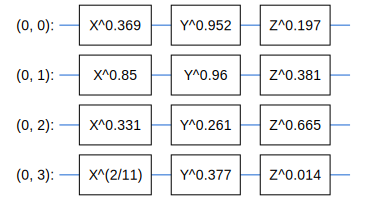

In [6]:
SVGCircuit(single_qubit_wall(
    cirq.GridQubit.rect(1,4), np.random.uniform(size=(4, 3))))

In [7]:
def v_theta(qubits):
    """Prepares a circuit that generates V(\theta)."""
    ref_paulis = [
      cirq.X(q0) * cirq.X(q1) + \
      cirq.Y(q0) * cirq.Y(q1) + \
      cirq.Z(q0) * cirq.Z(q1) for q0, q1 in zip(qubits, qubits[1:])
    ]
    exp_symbols = list(sympy.symbols('ref_0:'+str(len(ref_paulis))))
    return tfq.util.exponential(ref_paulis, exp_symbols), exp_symbols

Symbols found in circuit:[ref_0]


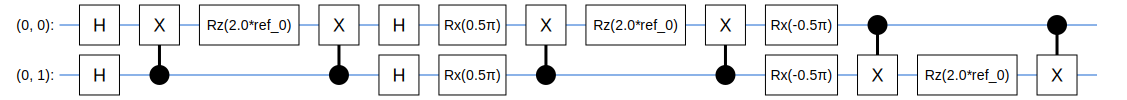

In [8]:
test_circuit, test_symbols = v_theta(cirq.GridQubit.rect(1, 2))
print(f'Symbols found in circuit:{test_symbols}')
SVGCircuit(test_circuit)

In [9]:
def prepare_pqk_circuits(qubits, classical_source, n_trotter=9):
    """Prepare the pqk feature circuits around a dataset."""
    n_qubits = len(qubits)
    n_points = len(classical_source)

    # Prepare random single qubit rotation wall.
    random_rots = np.random.uniform(-2, 2, size=(n_qubits, 3))
    initial_U = single_qubit_wall(qubits, random_rots)

    # Prepare parametrized V
    V_circuit, symbols = v_theta(qubits)
    exp_circuit = cirq.Circuit(V_circuit for t in range(n_trotter))

    # Convert to `tf.Tensor`
    initial_U_tensor = tfq.convert_to_tensor([initial_U])
    initial_U_splat = tf.tile(initial_U_tensor, [n_points])

    full_circuits = tfq.layers.AddCircuit()(
      initial_U_splat, append=exp_circuit)
    # Replace placeholders in circuits with values from `classical_source`.
    return tfq.resolve_parameters(
      full_circuits, tf.convert_to_tensor([str(x) for x in symbols]),
      tf.convert_to_tensor(classical_source*(n_qubits/3)/n_trotter))

In [10]:
x_train = data.x_train.reshape(-1,9)
x_test = data.x_test.reshape(-1,9)

In [11]:
DATASET_DIM = 9
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)
q_x_train_circuits = prepare_pqk_circuits(qubits, x_train)
q_x_test_circuits = prepare_pqk_circuits(qubits, x_test)

In [12]:
def get_pqk_features(qubits, data_batch):
    """Get PQK features based on above construction."""
    ops = [[cirq.X(q), cirq.Y(q), cirq.Z(q)] for q in qubits]
    ops_tensor = tf.expand_dims(tf.reshape(tfq.convert_to_tensor(ops), -1), 0)
    batch_dim = tf.gather(tf.shape(data_batch), 0)
    ops_splat = tf.tile(ops_tensor, [batch_dim, 1])
    exp_vals = tfq.layers.Expectation()(data_batch, operators=ops_splat)
    rdm = tf.reshape(exp_vals, [batch_dim, len(qubits), -1])
    return rdm

In [13]:
x_train_pqk = get_pqk_features(qubits, q_x_train_circuits)
x_test_pqk = get_pqk_features(qubits, q_x_test_circuits)
print('New PQK training dataset has shape:', x_train_pqk.shape)
print('New PQK testing dataset has shape:', x_test_pqk.shape)

New PQK training dataset has shape: (100, 10, 3)
New PQK testing dataset has shape: (100, 10, 3)


In [14]:
def compute_kernel_matrix(vecs, gamma):
    """Computes d[i][j] = e^ -gamma * (vecs[i] - vecs[j]) ** 2 """
    scaled_gamma = gamma / (tf.cast(tf.gather(tf.shape(vecs), 1), tf.float32) * tf.math.reduce_std(vecs))
    return scaled_gamma * tf.einsum('ijk->ij',(vecs[:,None,:] - vecs) ** 2)

def get_spectrum(datapoints, gamma=1.0):
    """Compute the eigenvalues and eigenvectors of the kernel of datapoints."""
    KC_qs = compute_kernel_matrix(datapoints, gamma)
    S, V = tf.linalg.eigh(KC_qs)
    S = tf.math.abs(S)
    return S, V

In [15]:
S_pqk, V_pqk = get_spectrum(
    tf.reshape(tf.concat([x_train_pqk, x_test_pqk], 0), [-1, len(qubits) * 3]))

S_original, V_original = get_spectrum(
    tf.cast(tf.concat([x_train, x_test], 0), tf.float32), gamma=0.005)

print('Eigenvectors of pqk kernel matrix:', V_pqk)
print('Eigenvectors of original kernel matrix:', V_original)

Eigenvectors of pqk kernel matrix: tf.Tensor(
[[-0.05861564  0.06606742 -0.01445209 ... -0.12633847  0.01004228
   0.0609736 ]
 [-0.09074094 -0.0482437   0.03341128 ... -0.00792502 -0.6178855
   0.0728008 ]
 [-0.08010418 -0.07584776  0.04801812 ...  0.10825794 -0.03722573
   0.10046869]
 ...
 [ 0.07716197  0.09263343  0.0207109  ...  0.06566181  0.09328894
   0.07066144]
 [ 0.08256613  0.09746503  0.00085111 ... -0.15536202  0.04699476
   0.06936362]
 [ 0.06995799 -0.02504404  0.07149449 ...  0.02367405  0.0149882
   0.0685478 ]], shape=(200, 200), dtype=float32)
Eigenvectors of original kernel matrix: tf.Tensor(
[[-0.01485219 -0.08349728  0.01797059 ... -0.05996002  0.04708398
   0.04488817]
 [-0.18340698  0.15891331  0.01466258 ... -0.01404849  0.48948944
   0.1414669 ]
 [ 0.05182741  0.0459606   0.06905736 ... -0.12773456  0.01159237
   0.098722  ]
 ...
 [ 0.01854927 -0.08124254  0.10922255 ... -0.00791932 -0.00700202
   0.0564884 ]
 [-0.00790814 -0.09038292 -0.00645613 ...  0.01847

In [16]:
def get_stilted_dataset(S, V, S_2, V_2, lambdav=1.1):
    """Prepare new labels that maximize geometric distance between kernels."""
    S_diag = tf.linalg.diag(S ** 0.5)
    S_2_diag = tf.linalg.diag(S_2 / (S_2 + lambdav) ** 2)
    scaling = S_diag @ tf.transpose(V) @ \
            V_2 @ S_2_diag @ tf.transpose(V_2) @ \
            V @ S_diag

    # Generate new lables using the largest eigenvector.
    _, vecs = tf.linalg.eig(scaling)
    new_labels = tf.math.real(
      tf.einsum('ij,j->i', tf.cast(V @ S_diag, tf.complex64), vecs[-1])).numpy()
    # Create new labels and add some small amount of noise.
    final_y = new_labels > np.median(new_labels)
    noisy_y = (final_y ^ (np.random.uniform(size=final_y.shape) > 0.95))
    return noisy_y

In [17]:
y_relabel = get_stilted_dataset(S_pqk, V_pqk, S_original, V_original)
y_train_new, y_test_new = y_relabel[:100], y_relabel[100:]

In [18]:
#docs_infra: no_execute
def create_pqk_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[len(qubits) * 3,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

pqk_model = create_pqk_model()
pqk_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

pqk_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                992       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [19]:
#docs_infra: no_execute
pqk_history = pqk_model.fit(tf.reshape(x_train_pqk, [100, -1]),
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(tf.reshape(x_test_pqk, [100, -1]), y_test_new))

In [20]:
#docs_infra: no_execute
def create_fair_classical_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[DATASET_DIM,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                320       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


In [21]:
#docs_infra: no_execute
classical_history = model.fit(x_train,
          y_train_new,
          batch_size=32,
          epochs=10,
          verbose=0,
          validation_data=(x_test, y_test_new))

In [27]:
args = argparse.Namespace()
args.feature_map = "AmplitudeMap"
args.ansatz = "Cong"
args.n_layers = 1
args.num_workers = 4

data_config = {
    'input_dims': x_train_pqk.shape[1:]
}

vqc = VQC(data_config, args)

N Layers:  1
N Qubits:  5
Cluster State:  None
DRC:  None
Feature Map:  <qml_hep_lhc.encodings.amplitude.AmplitudeMap object at 0x7f0a729bd510>
Ansatz:  <qml_hep_lhc.ansatzes.cong.Cong object at 0x7f0a7295d3d0>
Num data symbols:  32
In symbols:  [[x0 x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11 x12 x13 x14 x15 x16 x17 x18 x19
  x20 x21 x22 x23 x24 x25 x26 x27 x28 x29 x30 x31]]
In symbols shape:  (1, 32)


In [28]:
vqc.compile()

In [29]:
vqc.build_graph().summary()

n_qubits: 5
num_layers: 2
n_layers: 1
var_symbols: [[θ0 θ1 θ2 θ3 θ4 θ5 θ6 θ7 θ8 θ9 θ10 θ11 θ12 θ13 θ14 θ15 θ16 θ17 θ18 θ19
  θ20]]
observable: [cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.GridQubit(0, 4), cirq.Z)}): (-0.5+0j), frozenset(): (0.5+0j)}))]
self.observable:  ListWrapper([cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.GridQubit(0, 4), cirq.Z)}): (-0.5+0j), frozenset(): (0.5+0j)}))])
Theta shape:  (1, 21)
Expr map:  cirq.ExpressionMap({2*asin((Abs(x16)**2 + Abs(x17)**2 + Abs(x18)**2 + Abs(x19)**2 + Abs(x20)**2 + Abs(x21)**2 + Abs(x22)**2 + Abs(x23)**2 + Abs(x24)**2 + Abs(x25)**2 + Abs(x26)**2 + Abs(x27)**2 + Abs(x28)**2 + Abs(x29)**2 + Abs(x30)**2 + Abs(x31)**2)**0.5*(Abs(x0)**2 + Abs(x1)**2 + Abs(x10)**2 + Abs(x11)**2 + Abs(x12)**2 + Abs(x13)**2 + Abs(x14)**2 + Abs(x15)**2 + Abs(x16)**2 + Abs(x17)**2 + Abs(x18)**2 + Abs(x19)**2 + Abs(x2)**2 + Abs(x20)**2 + Abs(x21)**2 + Abs(x22)**2 + Abs(x23)**2 + Abs(x24)**2 + Abs(x25)**2 + Abs(x26)**2 + Abs(x27)**2 + Abs(x28)**2 + Abs

Model: "VQC-AmplitudeMap-Cong"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 TwoLayerPQC (TwoLayerPQC)   (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [30]:
data.x_train = tf.reshape(x_train_pqk, [100, -1])
data.y_train = y_train_new
data.x_test = tf.reshape(x_test_pqk, [100, -1])
data.y_test = y_test_new

In [ ]:
qhistory = vqc.fit(data, [])

Epoch 1/1000
1/1 [==============================] - 1s 774ms/step - loss: 6.7055e-08 - auc_1: 0.3908 - accuracy: 0.3750 - val_loss: 7.1526e-08 - val_auc_1: 0.8125 - val_accuracy: 0.7500
Epoch 2/1000
1/1 [==============================] - 1s 738ms/step - loss: 6.7055e-08 - auc_1: 0.3908 - accuracy: 0.3750 - val_loss: 7.1526e-08 - val_auc_1: 0.8125 - val_accuracy: 0.7500
Epoch 3/1000
1/1 [==============================] - 1s 734ms/step - loss: 6.7055e-08 - auc_1: 0.3908 - accuracy: 0.3750 - val_loss: 7.1526e-08 - val_auc_1: 0.8125 - val_accuracy: 0.7500
Epoch 4/1000
1/1 [==============================] - 1s 724ms/step - loss: 6.7055e-08 - auc_1: 0.3908 - accuracy: 0.3750 - val_loss: 7.1526e-08 - val_auc_1: 0.8125 - val_accuracy: 0.7500
Epoch 5/1000
1/1 [==============================] - 1s 707ms/step - loss: 6.7055e-08 - auc_1: 0.3908 - accuracy: 0.3750 - val_loss: 7.1526e-08 - val_auc_1: 0.8125 - val_accuracy: 0.7500
Epoch 6/1000
1/1 [==============================] - 1s 726ms/step - lo

Epoch 45/1000
1/1 [==============================] - 1s 713ms/step - loss: 6.7055e-08 - auc_1: 0.3908 - accuracy: 0.3750 - val_loss: 7.1526e-08 - val_auc_1: 0.8125 - val_accuracy: 0.7500
Epoch 46/1000
1/1 [==============================] - 1s 708ms/step - loss: 6.7055e-08 - auc_1: 0.3908 - accuracy: 0.3750 - val_loss: 7.1526e-08 - val_auc_1: 0.8125 - val_accuracy: 0.7500
Epoch 47/1000
1/1 [==============================] - 1s 732ms/step - loss: 6.7055e-08 - auc_1: 0.3908 - accuracy: 0.3750 - val_loss: 7.1526e-08 - val_auc_1: 0.8125 - val_accuracy: 0.7500
Epoch 48/1000
1/1 [==============================] - 1s 771ms/step - loss: 6.7055e-08 - auc_1: 0.3908 - accuracy: 0.3750 - val_loss: 7.1526e-08 - val_auc_1: 0.8125 - val_accuracy: 0.7500
Epoch 49/1000
1/1 [==============================] - 1s 732ms/step - loss: 6.7055e-08 - auc_1: 0.3908 - accuracy: 0.3750 - val_loss: 7.1526e-08 - val_auc_1: 0.8125 - val_accuracy: 0.7500
Epoch 50/1000
1/1 [==============================] - 1s 705ms/ste

In [ ]:
#docs_infra: no_execute
plt.figure(figsize=(10,5))
plt.plot(classical_history.history['accuracy'], label='accuracy_classical')
plt.plot(classical_history.history['val_accuracy'], label='val_accuracy_classical')
plt.plot(pqk_history.history['accuracy'], label='accuracy_quantum')
plt.plot(pqk_history.history['val_accuracy'], label='val_accuracy_quantum')
plt.plot(qhistory.history['accuracy'], label='accuracy_quantum_model')
plt.plot(qhistory.history['val_accuracy'], label='val_accuracy_quantum_model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()